# **Skin Disease Classification Ensemble Model (ResNet + DenseNet)**

Install packages

In [ ]:

!pip install torch torchvision tensorflow keras opencv-python scikit-learn matplotlib seaborn numpy pandas albumentations

Imports

In [ ]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from tqdm import tqdm
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import drive
import copy

SETUP

In [ ]:
# Enable GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive
drive.mount('/content/drive')

Using device: cuda
Mounted at /content/drive


# Define constants and hyperparameters

In [ ]:
# config
TRAIN_DIR = "/content/drive/MyDrive/571/final project/train"
TEST_DIR = "/content/drive/MyDrive/571/final project/test"
class Config:
    # Dataset
    IMAGE_SIZE = 224
    HEIGHT = 224
    WIDTH  = 224
    TRAIN_DIR = "/content/drive/MyDrive/571/final project/train"
    TEST_DIR = "/content/drive/MyDrive/571/final project/test"

    MEAN = [0.485, 0.456, 0.406]
    STD  = [0.229, 0.224, 0.225]



    # Training
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    FINE_TUNE_LR = 1e-4
    FROZEN_EPOCHS = 16
    FINE_TUNE_EPOCHS = 40 #early stopping will be impl

    # Model
    DROPOUT_RATE = 0.5
    NUM_CLASSES = 23

    # Early Stopping
    EARLY_STOPPING_PATIENCE = 4

config = Config()

train_dir = "/content/drive/MyDrive/571/final project/train"
test_dir = "/content/drive/MyDrive/571/final project/test"

# Print configuration
print("\n" + "="*60)
print("CONFIGURATION")
print("="*60)
print(f"Image Size: {config.IMAGE_SIZE}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Learning Rate: {config.LEARNING_RATE}")
print(f"Frozen Epochs: {config.FROZEN_EPOCHS}")
print(f"Fine-tune Epochs: {config.FINE_TUNE_EPOCHS}")
print(f"Number of Classes: {config.NUM_CLASSES}")
print("="*60)


CONFIGURATION
Image Size: 224
Batch Size: 32
Learning Rate: 0.001
Frozen Epochs: 16
Fine-tune Epochs: 40
Number of Classes: 23


Upload Dataset from Drive

In [ ]:
import os

DATA_ROOT = "/content/data"

print("Data root exists:", os.path.exists(DATA_ROOT))
print("Train exists:", os.path.exists(f"{DATA_ROOT}/train"))
print("Test exists:", os.path.exists(f"{DATA_ROOT}/test"))

if os.path.exists(f"{DATA_ROOT}/train"):
    print("\nTrain classes:", os.listdir(f"{DATA_ROOT}/train"))

    total_train = sum(len(files) for _, _, files in os.walk(f"{DATA_ROOT}/train"))
    print("Total train images:", total_train)

if os.path.exists(f"{DATA_ROOT}/test"):
    total_test = sum(len(files) for _, _, files in os.walk(f"{DATA_ROOT}/test"))
    print("Total test images:", total_test)


Data root exists: False
Train exists: False
Test exists: False


# Data Augmentations

In [ ]:

MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # Convert PIL Image to numpy array
        img = np.array(img)
        # Apply Albumentations transform
        img = self.transform(image=img)['image']
        return img



In [ ]:

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transform = A.Compose(
    transforms=[

        A.Resize(256, 256),
            #A.RandomResizedCrop(224, 224, scale=(0.8, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=30, p=0.7),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=0.5),

            # Color transformations
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.2, p=0.5),

            # select augmentations
            A.OneOf([
                A.MotionBlur(p=0.2),
                A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.3),



        # Small rotations of ±15 degrees:
        A.Rotate(
            limit=(-15, 15),
            interpolation=cv2.INTER_AREA,
            border_mode=cv2.BORDER_CONSTANT,
            fill=0,
            p=0.5
        ),

        # Small shift to account for different scanning positions
        A.ShiftScaleRotate(
            shift_limit=0.05,
            scale_limit=0.05,
            rotate_limit=0,
            interpolation=cv2.INTER_AREA,
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            p=0.3
        ),



        A.OneOf([
            A.GaussNoise(std_range=(0.01, 0.03), mean_range=(0.0, 0.0), p=0.5),
            A.GaussianBlur(blur_limit=(3, 3), p=0.5),
        ], p=0.10),

        # Set size and normalize for ImageNet:
        A.Resize(height=224, width=224),

        #normalize
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ],
    p=1.0,
)
train_transform = AlbumentationsTransform(train_transform)


val_transform = A.Compose(
    transforms=[
        A.Resize(height=224, width=224),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ],
    p=1.0,
)
val_transform = AlbumentationsTransform(val_transform)






/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2045424124.py:37: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(


Create datasets with augmentations

In [ ]:
# datasets
def create_datasets(train_dir, test_dir):
    print("loading datasets..")

    # Load datasets using the globally defined transforms
    train_dataset = ImageFolder(TRAIN_DIR, transform= train_transform)
    test_dataset = ImageFolder(TEST_DIR, transform= val_transform)

    # Update number of classes based on actual dataset
    global config # Ensure config is recognized as global
    config.NUM_CLASSES = len(train_dataset.classes)

    print(f"Number of classes: {config.NUM_CLASSES}")
    print(f"Class names: {train_dataset.classes}")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Split train into train and validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size

    train_subset, val_dataset = random_split(
        train_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"\nAfter splitting:")
    print(f"Training samples: {len(train_subset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    return train_subset, val_dataset, test_dataset, train_dataset.classes # Return class_names as well

# Call create_datasets
train_subset, val_dataset, test_dataset, class_names = create_datasets(config.TRAIN_DIR, config.TEST_DIR)
print(f"\nConfirm same as above: splitting:")
print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


loading datasets..
Number of classes: 23
Class names: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
Train samples: 15557
Test samples: 4

visualize samples

In [ ]:
def denormalize(img, mean, std):
    """
    Undo normalization for visualization.

    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean


In [ ]:
import random
import matplotlib.pyplot as plt

#denormalize
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

def denormalize(img, mean=MEAN, std=STD):
    mean = torch.tensor(mean).view(3,1,1)
    std  = torch.tensor(std).view(3,1,1)
    return img * std + mean

#visualize func
def visualize_train_samples(dataset, class_names, num_samples):

  indices = random.sample(range(len(dataset)), num_samples)

  plt.figure(figsize=(16, 6))

  for i, idx in enumerate(indices):
        img, label = train_subset[idx]

        # Undo normalization for display
        img = denormalize(img).clamp(0, 1)
        img = img.permute(1, 2, 0)          #

        plt.subplot(2, (num_samples + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(class_names[label], fontsize=12)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

def visualize_val_samples(dataset, class_names, num_samples):

  indices = random.sample(range(len(dataset)), num_samples)

  plt.figure(figsize=(16, 6))

  for i, idx in enumerate(indices):
        img, label = val_dataset[idx]

        # Undo normalization for display
        img = denormalize(img).clamp(0, 1)
        img = img.permute(1, 2, 0)

        plt.subplot(2, (num_samples + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(class_names[label], fontsize=12)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

def visualize_test_samples(dataset, class_names, num_samples):

  indices = random.sample(range(len(dataset)), num_samples)

  plt.figure(figsize=(16, 6))

  for i, idx in enumerate(indices):
        img, label = test_dataset[idx]

        # Undo normalization for display
        img = denormalize(img).clamp(0, 1)
        img = img.permute(1, 2, 0)

        plt.subplot(2, (num_samples + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(class_names[label], fontsize=12)
        plt.axis("off")
        plt.tight_layout()
        plt.show()







Training Sample Images


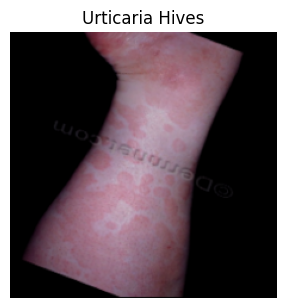

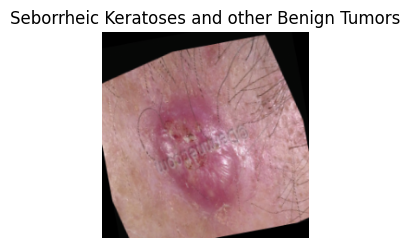

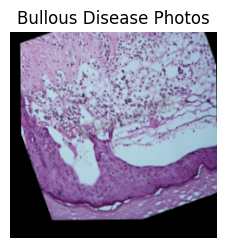

 Validation Sample Images


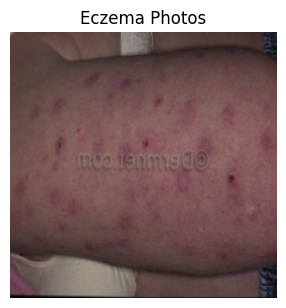

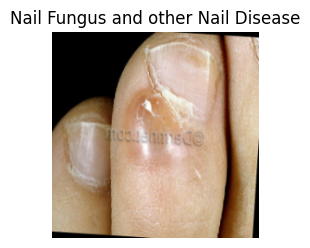

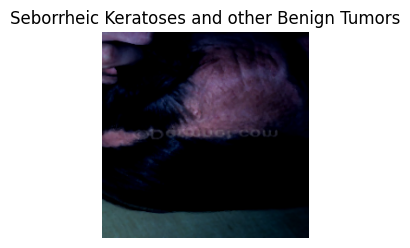

 Test Sample Images


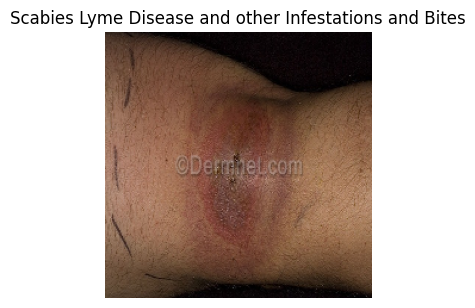

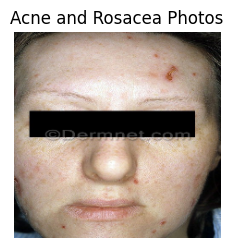

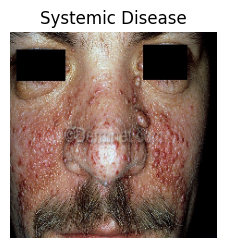

In [ ]:
print(f"Training Sample Images")
visualize_train_samples(train_subset, class_names, 3)
print(f" Validation Sample Images")
visualize_val_samples(val_dataset, class_names, 3)
print(f" Test Sample Images")
visualize_test_samples(test_dataset, class_names, 3)



Create dataloaders

In [ ]:

def create_dataloaders(train_dataset, val_dataset, test_dataset):
  #dataloaders for trainign



    # Create dataloaders
    train_loader = DataLoader(train_dataset,batch_size=config.BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False, #no need
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"\nDataloader Information:")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_dataloaders(train_subset, val_dataset, test_dataset)





Dataloader Information:
Training batches: 389
Validation batches: 98
Test batches: 126


In [ ]:
# Enable GPU again
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def calculate_class_weights(dataloader, num_classes):
  #class weights calc
    class_counts = torch.zeros(num_classes) #count how many samples per class
    for _, labels in dataloader:
        for label in labels:
            class_counts[label] += 1 #how many training samples per class add

    # Avoid division by zero
    class_counts[class_counts == 0] = 1

    total_samples = class_counts.sum()
    class_weights = total_samples / (num_classes * class_counts) #assign higher weight (higher penalty) for rare classes
    class_weights = class_weights / class_weights.sum()                    #lower weight (lower penalty) for frequent classes

    print(f"\nClass weights calculated:")
    for i, weight in enumerate(class_weights):
        print(f"  Class {i}: {weight:.4f}")

    return class_weights.to(device)

# Create dataloaders and calculate weights

class_weights = calculate_class_weights(train_loader, config.NUM_CLASSES)

# Build Ensemble model architecture

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES, dropout_rate=config.DROPOUT_RATE, hidden_features=256):
        super().__init__()

        self.num_classes = num_classes
        self.hidden_features = hidden_features

        print(f"Initializing Ensemble Model with:")
        print(f"- Num classes: {num_classes}")
        print(f"- Dropout rate: {dropout_rate}")

        # Load pretrained models resent and densenet
        # Backbones
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        # Get number of features from each model
        num_features_resnet = self.resnet.fc.in_features
        num_features_densenet = self.densenet.classifier.in_features

        print(f"ResNet features: {num_features_resnet}")
        print(f"DenseNet features: {num_features_densenet}")

        # Replace classifier heads with dropout
        self.resnet.fc = self._create_classifier_head(num_features_resnet, 256, dropout_rate, hidden_features)
        self.densenet.classifier = self._create_classifier_head(num_features_densenet, 256, dropout_rate, hidden_features)

        # Final classifier: (256 + 256) num_classes
        self.combined_classifier = self._create_classifier_head(
             in_features=512, out_features=num_classes, dropout_rate=dropout_rate, hidden_features=hidden_features
         )


        # Combined classifier with dropout
        combined_features = 512  # 256 from each model
        #actual_combined_features = torch.cat((num_features_resnet, num_features_densenet), dim=1)

        print(f"does output layers = combined head layers?: {hidden_features * 2 == combined_features}")



        # Count parameters
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")


    def _create_classifier_head(self, in_features, out_features, dropout_rate, hidden_features):

        layers = [
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, hidden_features),
            nn.BatchNorm1d(hidden_features),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),
            nn.Linear(hidden_features, hidden_features // 2),
            nn.ReLU(),
            nn.Linear(hidden_features // 2, hidden_features // 4),
            nn.ReLU(),
             nn.Linear(hidden_features // 4, out_features)

        ]

        return nn.Sequential(*layers)

    def forward(self, x):
        features_resnet = self.resnet(x)
        features_densenet = self.densenet(x)
        combined_layers = torch.cat((features_resnet, features_densenet), dim=1)
        output = self.combined_classifier(combined_layers)
        return output

# Create model
model = EnsembleModel(num_classes=config.NUM_CLASSES,
                      dropout_rate=config.DROPOUT_RATE,
                      hidden_features=256)
model = model.to(device)

print(f"\nModel created")

# Loss function
#use this one when weight adjustement for underrepresented classes, block of code done running
criterion = nn.CrossEntropyLoss(weight=class_weights)

#criterion = nn.CrossEntropyLoss()
print(f"\nUsing class-weighted CrossEntropyLoss")





freeze func

In [ ]:

def freeze_backbone(model):
    """Freeze backbone layers, keep classifier head trainable"""
    print("\nFreezing backbone layers...")

    # Freeze ResNet
    for param in model.resnet.parameters():
        param.requires_grad = False

    # Freeze DenseNet
    for param in model.densenet.parameters():
        param.requires_grad = False

    # Keep classifier trainable
    for param in model.resnet.fc.parameters():
        param.requires_grad = True
    for param in model.densenet.classifier.parameters():
        param.requires_grad = True
    for param in model.combined_classifier.parameters():
        param.requires_grad = True

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters after freezing: {trainable_params:,}")

    return model

unfreeze/fine tune

In [ ]:
def unfreeze_restnet_for_finetuning(model, num_layers=4):
        """Unfreeze deeper layers for fine-tuning """

        print(f"\nUnfreezing last {num_layers} layers for fine-tuning...")

        # Unfreeze last N layers of ResNet
        resnet_layers = list(model.resnet.children())
        for layer in resnet_layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True




        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable parameters after unfreezing resnet: {trainable_params:,}")

        return model

def unfreeze_densenet_for_finetuning(model, num_layers=4):
        """Unfreeze deeper layers for fine-tuning """

        print(f"\nUnfreezing last {num_layers} layers for fine-tuning...")



        # Unfreeze last num_layers of DenseNet
        densenet_layers = list(model.densenet.children())
        for layer in densenet_layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True


        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable parameters after unfreezing densenet: {trainable_params:,}")

        return model

def unfreeze_for_finetuning(model, num_layers=4):
        """Unfreeze deeper layers for fine-tuning """

        print(f"\nUnfreezing last {num_layers} layers for fine-tuning...")

         # Unfreeze last N layers of ResNet
        resnet_layers = list(model.resnet.children())
        for layer in resnet_layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True




        # Unfreeze last num_layers of DenseNet
        densenet_layers = list(model.densenet.children())
        for layer in densenet_layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True


        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable parameters after unfreezing densenet: {trainable_params:,}")

        return model





# Training and Evaluation

Train Epoch Function

In [ ]:

def train_epoch(model, dataloader, criterion, optimizer, device, phase='training'):
    #train for one epoch
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc=f"Training ({phase})"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc



Validate Epoch Function

In [ ]:
def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels


# Train Models




Training viuslaization helper

In [ ]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs, phase):
    """Plot training history for a phase"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{phase} - Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, train_accs, 'b-', label='Train Acc', linewidth=2)
    ax2.plot(epochs, val_accs, 'r-', label='Val Acc', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{phase} - Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f'Training History - {phase} Phase', fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
##>?????/

train frozen backbone

# Train and Eval Model with frozen backbone and only trainable Classifier Heads

In [ ]:
# Freeze backbone initially
model = freeze_backbone(model)
# sanity check
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Done freezing backbone. Trainable params: {trainable:,} / {total:,}")


# TRAIN FROZEN BACKBONE
def train_frozen_backbone(model, train_loader, val_loader, criterion, num_epochs=config.FROZEN_EPOCHS):
    """Train model with frozen backbone"""
    print("\n" + "="*60)
    print("PHASE 1: TRAINING FROZEN BACKBONE")
    print("="*60)

    # Optimizer for classifier only
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config.LEARNING_RATE
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    # Track history
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    #starting vals
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # Train use train function
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, 'frozen')
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate use validation function
        val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update scheduler
        scheduler.step(val_loss)

        # Print results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_frozen_model.pth')
            print(f"Saved best frozen model (Acc: {val_acc:.2f}%)")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= config.EARLY_STOPPING_PATIENCE:
            print(f"\n Early stopping at epoch {epoch+1}")
            break

    # Plot results
    plot_training_history(train_losses, val_losses, train_accs, val_accs, "Frozen")

    return model, best_val_acc

# Train frozen backbone
model, frozen_best_acc = train_frozen_backbone(model, train_loader, val_loader, criterion)

# Train and Eval Model with frozen backbone and trainable Layers and Classifier Heads

In [ ]:
# unfreeze layers initially
model = unfreeze_for_finetuning(model, num_layers=4)

#sanity check
trainable2 = sum(p.numel() for p in model.parameters() if p.requires_grad)
total2 = sum(p.numel() for p in model.parameters())
print(f"Done unfreezing layers. Trainable params: {trainable2:,} / {total2:,}")


# FINE-TUNE UNFROZEN MODEL
def fine_tune_model(model, train_loader, val_loader, criterion, num_epochs=config.FINE_TUNE_EPOCHS):
    """Fine-tune model with unfrozen layers"""
    print("\n" + "="*60)
    print("PHASE 2: FINE-TUNING UNFROZEN LAYERS")
    print("="*60)

    # Unfreeze for fine-tuning
    model = unfreeze_for_finetuning(model, num_layers=4)

    # Optimizer for all trainable parameters
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config.FINE_TUNE_LR
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3    )

    # Track history
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = 0
    best_state = copy.deepcopy(model.state_dict())
    best_epoch = -1
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, 'fine-tune')
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate
        val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update scheduler
        scheduler.step(val_loss)

        # Print results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_finetuned_model.pth')
            print(f" Saved best fine-tuned model at epoch {epoch+1} (Acc: {val_acc:.2f}%)")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= config.EARLY_STOPPING_PATIENCE:
            print(f"\n Early stopping at epoch {epoch+1}")
            break

    #load model with best saved state before returning
    model.load_state_dict(best_state)

    # Plot results
    plot_training_history(train_losses, val_losses, train_accs, val_accs, "Fine-tune")

    return model, best_val_acc

#for using when reconnecting code
# ? torch.save({'model_state_dict': best_state, ...}, 'best_finetuned_model.pth')


# Fine-tune model
best_model, finetuned_best_acc = fine_tune_model(model, train_loader, val_loader, criterion)
print("Best fine-tuned val acc:", finetuned_best_acc)


In [ ]:
"""
use when restart code to load best model
def load_best_weights_into_model(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()
    print(f"Loaded weights from {ckpt_path} (epoch {ckpt['epoch']+1}, val_acc {ckpt['val_acc']:.2f}%)")
    return model

# recreate model architecture exactly the same as training
model_for_test = EnsembleModel(num_classes=config.NUM_CLASSES,
                               dropout_rate=config.DROPOUT_RATE,
                               hidden_features=256).to(device)

model_for_test = load_best_weights_into_model(model_for_test, "best_finetuned_model.pth", device)

# test
test_loss, test_acc, cm, y_true, y_pred = test_model(model_for_test, test_loader, criterion_test, class_names, device)
"""


*   use the best_model to create_mode
(^choose resnet, densenet, ensemlbe)
* evaluate using test_dataset on best_model
*  print acc and loss of testing


Evaluation of Model on Test Set

In [ ]:
def test_model(model, test_loader, criterion, class_names, device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)                 # (B, num_classes)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / total
    test_acc = 100.0 * correct / total

    cm = confusion_matrix(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    weighted_f1 = f1_score(all_labels, all_preds, average="weighted")

    print("\n" + "="*60)
    print("TEST RESULTS (BEST MODEL)")
    print("="*60)
    print(f"Test Loss     : {test_loss:.4f}")
    print(f"Test Accuracy : {test_acc:.2f}%")
    print(f"Macro F1      : {macro_f1:.4f}")
    print(f"Weighted F1   : {weighted_f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    return test_loss, test_acc, cm, all_labels, all_preds

test_loss, test_acc, cm, y_true, y_pred = test_model(best_model, test_loader, criterion_test, class_names, device)


In [ ]:


def plot_confusion_matrix(cm, class_names, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names)


In [ ]:

# TEST TIME AUGMENTATION (TTA)
def get_tta_transforms():
    """Create transforms for Test Time Augmentation"""
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    tta_transforms = [
        # Original
        A.Compose([
            A.Resize(config.IMAGE_SIZE, config.IMAGE_SIZE),
            A.Normalize(mean=MEAN, std=STD),
            ToTensorV2(),
        ]),
        # Horizontal flip
        A.Compose([
            A.Resize(config.IMAGE_SIZE, config.IMAGE_SIZE),
            A.HorizontalFlip(p=1.0),
            A.Normalize(mean=MEAN, std=STD),
            ToTensorV2(),
        ]),
        # Vertical flip
        A.Compose([
            A.Resize(config.IMAGE_SIZE, config.IMAGE_SIZE),
            A.VerticalFlip(p=1.0),
            A.Normalize(mean=MEAN, std=STD),
            ToTensorV2(),
        ]),
        # Rotation
        A.Compose([
            A.Resize(config.IMAGE_SIZE, config.IMAGE_SIZE),
            A.Rotate(limit=15, p=1.0),
            A.Normalize(mean=MEAN, std=STD),
            ToTensorV2(),
        ]),
    ]

    return [AlbumentationsTransform(t) for t in tta_transforms]

def predict_with_tta(model, image_path, tta_transforms, class_names):
    """Predict single image using TTA"""
    model.eval()
    image = Image.open(image_path).convert('RGB')

    predictions = []

    with torch.no_grad():
        for transform in tta_transforms:
            img_tensor = transform(image).unsqueeze(0).to(device)
            outputs = model(img_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predictions.append(probabilities)

    # Average predictions
    avg_probabilities = torch.mean(torch.stack(predictions), dim=0)
    confidence, predicted_idx = torch.max(avg_probabilities, 1)

    predicted_class = class_names[predicted_idx.item()]
    confidence_score = confidence.item() * 100

    print(f"TTA Prediction: {predicted_class} ({confidence_score:.1f}% confidence)")
    print(f"Used {len(tta_transforms)} augmentations")

    return predicted_class, confidence_score

def evaluate_with_tta(model, test_loader, tta_transforms):
    """Evaluate test set with TTA"""
    model.eval()
    all_preds = []
    all_labels = []

    print("\nEvaluating with Test Time Augmentation...")

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(test_loader, desc="TTA Evaluation")):
            batch_preds = []

            for transform in tta_transforms:
                transformed_batch = []
                for img in inputs:
                    img_pil = transforms.ToPILImage()(img)
                    img_transformed = transform(img_pil)
                    transformed_batch.append(img_transformed)

                transformed_batch = torch.stack(transformed_batch).to(device)
                outputs = model(transformed_batch)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                batch_preds.append(probabilities)

            # Average predictions
            avg_probabilities = torch.mean(torch.stack(batch_preds), dim=0)
            _, predicted = torch.max(avg_probabilities, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds) * 100

    print(f"\nTTA Evaluation Results:")
    print(f"Test Accuracy with TTA: {accuracy:.2f}%")

    return accuracy, all_preds, all_labels

# Load best model
checkpoint = torch.load('best_finetuned_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Create TTA transforms and evaluate
tta_transforms = get_tta_transforms()
tta_accuracy, tta_preds, tta_labels = evaluate_with_tta(model, test_loader, tta_transforms)

#ensemble tta

# Model ENsemble with TTA

In [ ]:
# ==============================
# MODEL ENSEMBLE WITH TTA
# ==============================
def create_ensemble_models():
    """Create multiple DIFFERENT models for ensemble"""
    models_list = []

    print("Creating ensemble models...")

    # Model 1: Our trained ResNet50 + DenseNet121 ensemble
    print("1. Loading ResNet50 + DenseNet121 Ensemble...")
    model1 = EnsembleModel(num_classes=config.NUM_CLASSES)
    checkpoint1 = torch.load('best_finetuned_model.pth')
    model1.load_state_dict(checkpoint1['model_state_dict'])
    model1 = model1.to(device)
    models_list.append(model1)

    # Model 2: ResNet50 only (different architecture)
    print("2. Loading ResNet50 only...")
    model2 = models.resnet50(pretrained=False)
    num_features = model2.fc.in_features
    model2.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, config.NUM_CLASSES)
    )
    # Load if you have a separately trained ResNet model, otherwise train it
    model2 = model2.to(device)
    models_list.append(model2)

    # Model 3: DenseNet121 only (different architecture)
    print("3. Loading DenseNet121 only...")
    model3 = models.densenet121(pretrained=False)
    num_features = model3.classifier.in_features
    model3.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, config.NUM_CLASSES)
    )
    model3 = model3.to(device)
    models_list.append(model3)

    print(f"Created ensemble of {len(models_list)} different models")
    return models_list

def ensemble_predict_with_tta(models, image_path, tta_transforms, class_names):
    """Ensemble prediction with TTA"""
    all_predictions = []

    for model_idx, model in enumerate(models):
        model.eval()
        model_predictions = []
        image = Image.open(image_path).convert('RGB')

        with torch.no_grad():
            for transform in tta_transforms:
                img_tensor = transform(image).unsqueeze(0).to(device)
                outputs = model(img_tensor)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                model_predictions.append(probabilities)

        # Average TTA predictions for this model
        avg_probabilities = torch.mean(torch.stack(model_predictions), dim=0)
        all_predictions.append(avg_probabilities)

    # Ensemble by averaging all model predictions
    ensemble_probabilities = torch.mean(torch.stack(all_predictions), dim=0)
    confidence, predicted_idx = torch.max(ensemble_probabilities, 1)

    predicted_class = class_names[predicted_idx.item()]
    confidence_score = confidence.item() * 100

    print(f"\nEnsemble + TTA Prediction:")
    print(f"Result: {predicted_class} ({confidence_score:.1f}% confidence)")
    print(f"Configuration: {len(models)} models × {len(tta_transforms)} TTA transforms")
    print(f"Total predictions: {len(models) * len(tta_transforms)}")

    return predicted_class, confidence_score

def evaluate_ensemble_with_tta(models, test_loader, tta_transforms):
    """Evaluate ensemble with TTA on test set"""
    all_preds = []
    all_labels = []

    print(f"\nEvaluating Ensemble of {len(models)} models with TTA...")
    print(f"Models: {[type(model).__name__ for model in models]}")

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(test_loader, desc="Ensemble TTA")):
            batch_ensemble_preds = []

            for model_idx, model in enumerate(models):
                model.eval()
                model_batch_preds = []

                for transform in tta_transforms:
                    transformed_batch = []
                    for img in inputs:
                        img_pil = transforms.ToPILImage()(img)
                        img_transformed = transform(img_pil)
                        transformed_batch.append(img_transformed)

                    transformed_batch = torch.stack(transformed_batch).to(device)
                    outputs = model(transformed_batch)
                    probabilities = torch.nn.functional.softmax(outputs, dim=1)
                    model_batch_preds.append(probabilities)

                # Average TTA predictions for this model
                avg_model_probabilities = torch.mean(torch.stack(model_batch_preds), dim=0)
                batch_ensemble_preds.append(avg_model_probabilities)

            # Ensemble predictions by averaging
            ensemble_probabilities = torch.mean(torch.stack(batch_ensemble_preds), dim=0)
            _, predicted = torch.max(ensemble_probabilities, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds) * 100

    print(f"\nEnsemble + TTA Results:")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Models used: {len(models)}")
    print(f"TTA transforms per model: {len(tta_transforms)}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix - {len(models)} Model Ensemble + TTA', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.savefig('ensemble_tta_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    return accuracy, all_preds, all_labels

# Create ensemble and evaluate
ensemble_models = create_ensemble_models()
ensemble_accuracy, ensemble_preds, ensemble_labels = evaluate_ensemble_with_tta(
    ensemble_models, test_loader, tta_transforms
)

In [ ]:
# ==============================
# FINAL RESULTS
# ==============================
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Dataset: {len(class_names)} classes")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"\nBest Validation Accuracy (Frozen): {frozen_best_acc:.2f}%")
print(f"Best Validation Accuracy (Fine-tuned): {finetuned_best_acc:.2f}%")
print(f"Test Accuracy with TTA: {tta_accuracy:.2f}%")
print(f"Test Accuracy with Ensemble + TTA: {ensemble_accuracy:.2f}%")
print("="*60)

In [ ]:
#model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
#model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
#model = EnsembleModel(num_classes=config.NUM_CLASSES,dropout_rate=config.DROPOUT_RATE, hidden_features=256)
#model = model.to(device)
